# Astro 330 "Computational Astrophysics"

## Homework 3

### Student: Dimitrios Tanoglidis 

### Problem 1) (25 points + 15 extra credit) Integrating ODEs with adaptive step size control and stiffness detection

### 1a) (15 points) Implementing an ODE integrator with step size control

Starting with the embedded Runge-Kutta-Fehlberg 5th order integration routine with constant step size, implement and test a version of the method with adaptive step size control to control accuracy of integration. Namely, you should specify parameters <tt>atol</tt> and <tt>rtol</tt> as input parameters to the integration routine and set up 
step size control so that the local integration error is smaller than 

$$e_{\rm tol} = a_{\rm tol} + r_{\rm tol}\vert y_{i+1}\vert, $$

where $a_{\rm tol}\ll r_{\rm tol} \vert y_{i+1}$ is some small absolute tolerance level to avoid issues with relative error for $y\approx 0$ and $r_{\rm tol}$ is *relative error* tolerance level. 

#### Useful info and hints: 
Algorithm for adaptive step size control is described in S 2.3.6 of my <a href="http://astro.uchicago.edu/~andrey/classes/a330f17/notes.pdf">notes</a>. You can just implement the algorithm of eq 2.8.7, but if you are curious you can experiment with the PI step controller, given by eq. 2.89. RKF45 routine without adaptive step size control is included below at the end of the homework. Examples of how it is used can be found in the <a href="https://github.com/a-kravtsov/a330f17/blob/master/ex06_odes.ipynb">ex06_odes.ipynb</a> notebook I used in class. 

You can choose to do 1c instead of this exercise for *additional* 15 extra-credit points. 

#### Required tests and follow up questions: 
Test your routine with adaptive step size control by solving the equation I considered as an example in class: 

$$\frac{dy}{dt} = e^{-t/\tau_2}\,\left(\frac{1}{\tau_1}-\frac{1}{\tau_2}\right)  - \frac{y}{\tau_1}; \ \ \ \ y_0=y(t=0) = 0.
$$

with $\tau_1 = 0.001$ and $\tau_2 = 1$ from $t=1$ to $t=5$, computing $y(t=1)$ using $y_0=0$ and solution below. Show that solution is accurate for the required input relative
tolerance level for say $r_{\rm tol}=10^{-6}$ and $r_{\rm tol}=10^{-10}$ compared to the exact solution:

$$
y(t) = e^{-t/\tau_2} - e^{-t/\tau_1} + y_0.
$$

by plotting fractional error of the numerical solution relative to exact one as a function of $t$ for different target values of $r_{\rm tol}$. 

### Solution


The first step for the solution of this problem is to change/adapt the given RKF45 routine in order to perform step size control and adapt the time step such us to achieve the required tolerance.

Here we outline the procedure:

First start with a given $t_{start}$ and $t_{end}$. We choose an arbitrary first time step; here our choice will be $h_{start} = (t_{end} - t_{start})/100$

Then we calculate using this starting step the $4^{th}$ order and $5^{th}$ order scheme estimates of the next step ($y_{i+1}$ in general). These are "temporary" solutions, in the sence that we will not append this $h$ or this solution $y$ to the array that keeps track of the solution.

Through these temporary solutions, we calculate the leading error $\tilde{e}_{i+1}$.

If $\tilde{e}_{i+1} > e_{tol}$, accept this solution. If not we define a new time step $h$ using eq. (2.87) from notes:

\begin{equation}
h \to wh\left(\frac{e_{tol}}{\tilde{e}_{i+1}}\right)^{1/(n_l +1 )} \qquad (1)
\end{equation}

Here we choose $w = 0.9$. Also $n_l$ is the order of the lowest order scheme between the two schemes that we compare. In our case $n_l = 4$. Thus, the new step is:

\begin{equation}
h \to 0.9h\left(\frac{e_{tol}}{\tilde{e}_{i+1}}\right)^{0.2} \qquad (2) 
\end{equation}

Actually, we bound this and we require:

\begin{equation}
h \to \max \left( 0.01h, \min\left(0.9h\left(\frac{e_{tol}}{\tilde{e}_{i+1}}\right)^{0.2}, 10.0h \right) \right) \qquad (3)
\end{equation}

which is equivalent to the inequality condition of eq. (2.87) with $\eta_{min} = 0.01$ and $\eta_{max} = 10$.

where $e_{tol} = a_{tol} + r_{tol}|y_{i+1,n_h}|$, where $y_{i+1,n_h}$ the temporary "solution" of the 5th order and $r_{tol}$ is provided when the user calls the function.

When we achieve the required tolerance, we append the $y_{i+1}$ to the arrat, increase the time and we are ready to move to the following step.

 




In [20]:
# Preliminary setup 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from code.plot_utils import plot_pretty

plot_pretty() 

#============================================================
#============================================================

###### Runge-Kutta-Fehlberg 5th-4th order scheme that is combined to determine step size adaptively

# Coefficients used to compute the independent variable argument of f
c20  =   2.500000000000000e-01  #  1/4
c30  =   3.750000000000000e-01  #  3/8
c40  =   9.230769230769231e-01  #  12/13
c50  =   1.000000000000000e+00  #  1
c60  =   5.000000000000000e-01  #  1/2

# Coefficients used to compute the dependent variable argument of f
c21 =   2.500000000000000e-01  #  1/4
c31 =   9.375000000000000e-02  #  3/32
c32 =   2.812500000000000e-01  #  9/32
c41 =   8.793809740555303e-01  #  1932/2197
c42 =  -3.277196176604461e+00  # -7200/2197
c43 =   3.320892125625853e+00  #  7296/2197
c51 =   2.032407407407407e+00  #  439/216
c52 =  -8.000000000000000e+00  # -8
c53 =   7.173489278752436e+00  #  3680/513
c54 =  -2.058966861598441e-01  # -845/4104
c61 =  -2.962962962962963e-01  # -8/27
c62 =   2.000000000000000e+00  #  2
c63 =  -1.381676413255361e+00  # -3544/2565
c64 =   4.529727095516569e-01  #  1859/4104
c65 =  -2.750000000000000e-01  # -11/40

# Coefficients used to compute 4th order RK estimate
a1  =   1.157407407407407e-01  #  25/216
a2  =   0.000000000000000e-00  #  0
a3  =   5.489278752436647e-01  #  1408/2565
a4  =   5.353313840155945e-01  #  2197/4104
a5  =  -2.000000000000000e-01  # -1/5
# Coefficients used to compute 5th order RK estimate
b1  =   1.185185185185185e-01  #  16.0/135.0
b2  =   0.000000000000000e-00  #  0
b3  =   5.189863547758284e-01  #  6656.0/12825.0
b4  =   5.061314903420167e-01  #  28561.0/56430.0
b5  =  -1.800000000000000e-01  # -9.0/50.0
b6  =   3.636363636363636e-02  #  2.0/55.0
# coefficients for the error (difference between 5th and 4th order)
e1 = b1-a1; e3 = b3-a3; e4 = b4-a4; e5 = b5-a5

def rkf45_adaptive(f, y_start, t_start, t_end, r_tol, *args):
    """
    5th order accurate embedded Runge-Kutta-Fehlberg scheme with adaprtive step  
    to solve ode dy/dt = f(t,y)
    
    The scheme simultaneously computes RK schemes of 4th and 5th order, which
    can be used to estimate the local error of the calculation, which can be used 
    for adaptive step control
    
    Parameters: 
    ----------------------------------------------------------------------------
    f - function object
              f(t, y, *args)
    y_start - float or vector of floats for system of equations
              initial value of y at t_start
    t_start - float 
              starting time
    t_end   - float
              end time
    r_tol   - float
              relative tolerance required 
    *args   - python list
              list of arguments to pass to f
              
    Returns:  
    ----------------------------------------------------------------------------
    tout     - numpy float array
               time of each step 
    yout     - numpy float array
               solution y(tout)
               
    """
    # First of all define a constant, small, absolute tolerance, a_tol. We take it to be 1.0e-15 ~ close to the machine tolerance
    
    a_tol = 1.0e-15
    
    
    t, y = t_start, y_start; 
    tout = np.array(t); yout = np.array(y)
    
    #Define a starting time step i. Take it to be 1/10th of the time difference between t_end and t_start
    

    h = (t_end - t_start)/100.0

    while t < t_end:
        # Here we define two values of e and e_tol that satisfy e > e_tol in order to be sure that we will enter
        # the loop at least one time
        e =10.0             
        e_tol = 1.0
        while (e > e_tol):
            
            #===========================================================================================
            #===========================================================================================
            #First caclute temporary solution - calculating temporary coefficients etc, in order to see 
            #how much to adapt the step
        
            #construct solutions of the 4th order and error (difference of 5th and 4th order)
            k1_tp = h * f(t, y, *args)
            k2_tp = h * f(t + c20*h, y + c21 * k1_tp, *args)
            k3_tp = h * f(t + c30*h, y + c31 * k1_tp + c32 * k2_tp, *args)
            k4_tp = h * f(t + c40*h, y + c41*k1_tp + c42*k2_tp + c43*k3_tp, *args)
            k5_tp = h * f(t + h    , y + c51*k1_tp + c52*k2_tp + c53*k3_tp + c54*k4_tp, *args)
            k6_tp = h * f(t + c60*h, y + c61*k1_tp + c62*k2_tp + c63*k3_tp + c64*k4_tp + c65*k5_tp, *args)
            # 4th order solution 
            w_tp  = a1 * k1_tp + a3 * k3_tp + a4 * k4_tp + a5 * k5_tp
            # 5th order solution
            y_tp = y + b1 * k1_tp + b3 * k3_tp + b4 * k4_tp + b5 * k5_tp + b6 * k6_tp
            # abs. difference between 4th and 5th order solutions
            e = abs(b6*k6_tp + e1*k1_tp + e3*k3_tp + e4*k4_tp + e5*k5_tp )
            
            #Calculate absolute tolerance
            e_tol =a_tol + r_tol*abs(y_tp)
        
            #Calculate the time step h that we will actually use
        
            h = max(0.01*h,min(0.9*h*((e_tol/e)**0.2),10.0*h))
        
        
        y = y_tp
        
        # new time   
        t += h      
        tout = np.vstack((tout,t)); yout = np.vstack((yout,y))
    return tout, yout



### Applying the adaptive RKF45 routine 

Now, we will apply the above routine to solve the differential equation:

\begin{equation}
\frac{d y}{d t} = e^{-t/\tau_2}\left(\frac{1}{\tau_1} - \frac{1}{\tau_2} \right) - \frac{y}{\tau_1} \qquad (4)
\end{equation}

The exact solution is:

\begin{equation}
y(t) = e^{-t/\tau_2} - e^{-t/\tau_1} + y_0 \qquad (5)
\end{equation}

with $y_0 = 0$. The intial condition at $t=1$ is then:

\begin{equation}
y(t=1) = e^{-1/\tau_2} - e^{-1/\tau_1} (6)
\end{equation}

For $\tau_1 =0.001$ and $\tau_2 = 1$ the above becomes : $y(t=1) = e^{-1/1} - e^{-1/0.001} \cong e^{-1} = 1/e$. We will use this as initial condition in our calculations:

$$y(t=1) = 1/e$$

In [21]:
# Define the function f(t,y) needed as an input for the adaptive rkf45

def f(t, y, *args):
    """ 
    Function - input for the rkf45
    
    """
    tau_1 = args[0]
    tau_2 = args[1]
    
    fact_1 = np.exp(-t/tau_2)
    fact_2 = 1.0/tau_1 - 1.0/tau_2
    fact_3 = y/tau_1
    
    return fact_1*fact_2 - fact_3

#=====================================================================
#=====================================================================




taf_1 = 0.001
taf_2 = 1.0



#Numerical solution of the differential equation

I = rkf45_adaptive(f, 1.0/np.e, 1.0, 5.0, 1.0e-6, taf_1, taf_2)
t_sol, y_sol = I[0], I[1]


# Exact solution - using the same time steps as the numerical
y_exact = np.exp(-t_sol/taf_2) - np.exp(-t_sol/taf_1)




  

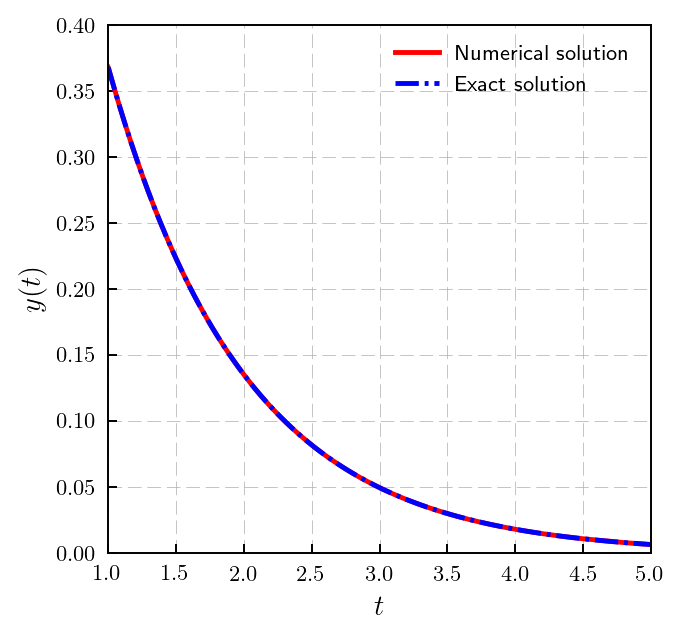

In [22]:
plt.figure(figsize=(4,4))


plt.plot(t_sol,y_sol, c='r', linewidth=2, label=r'Numerical solution' )

plt.plot(t_sol,y_exact, c='b', linewidth = 2, ls='-.', label =r'Exact solution')

plt.xlim(1.0,5.0);plt.ylim(0.0,0.4)

plt.xlabel('$t$', fontsize=12); plt.ylabel('$y(t)$', fontsize=12)

plt.grid(ls='--', linewidth=0.3)

plt.legend(frameon=False, loc='upper right', fontsize=9)

plt.show()

### Plotting fractional errors

Now, for two different values of relative tolerance, $r_{tol}$, namely $r_{tol} = 10^{-6}$ and $r_{tol} = 10^{-10}$ we plot the fractional errors between the numerical and the exact solution, defined as:

\begin{equation}
\mbox{FD}(t) = \frac{|y_{numer}(t)-y_{exact}|}{y_{exact}(t)} \qquad (7)
\end{equation}

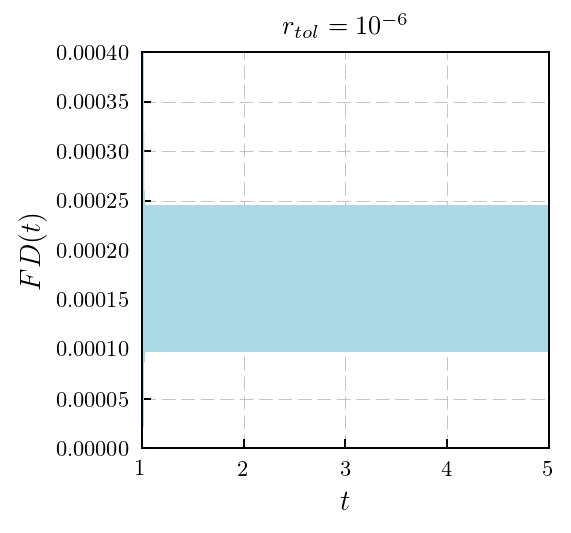

In [23]:
#===========================================================
#===========================================================
# Solution and frac error with r_tol = 10^{-6}

#Numerical solution of the differential equation

I = rkf45_adaptive(f, 1.0/np.e, 1.0, 5.0, 1.0e-6, taf_1, taf_2)
t_sol_1, y_sol_1 = I[0], I[1]

# Exact solution - using the same time steps as the numerical
y_exact_1 = np.exp(-t_sol_1/taf_2) - np.exp(-t_sol_1/taf_1)

#Calculation of the fractional error

FD_1 = np.abs(y_sol_1 - y_exact_1)/y_exact_1


#===========================================================
#===========================================================

# Solution and frac error with r_tol = 10^{-10}

#Numerical solution of the differential equation

J = rkf45_adaptive(f, 1.0/np.e, 1.0, 5.0, 1.0e-10, taf_1, taf_2)
t_sol_2, y_sol_2 = J[0], J[1]

# Exact solution - using the same time steps as the numerical
y_exact_2 = np.exp(-t_sol_2/taf_2) - np.exp(-t_sol_2/taf_1)

#Calculation of the fractional error

FD_2 = np.abs(y_sol_2 - y_exact_2)/y_exact_2

#=========================================================================
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#=========================================================================
#Plotting them 

plt.figure(figsize=(3,3))


plt.plot(t_sol_1,FD_1, c='lightblue', linewidth=0.5 )


plt.xlim(1.0,5.0)
plt.ylim(0.0,0.0004)

plt.title('$r_{tol}= 10^{-6}$')


plt.xlabel('$t$', fontsize=12); plt.ylabel('$FD(t)$', fontsize=12)

plt.grid(ls='--', linewidth=0.3)

plt.legend(frameon=False, loc='upper right', fontsize=9)

plt.show()



Actually, while it seems to be constant, the fractional difference oscillates. In order to see this, let's plot a detail of it, from $t=1.0$ to $t=1.1$

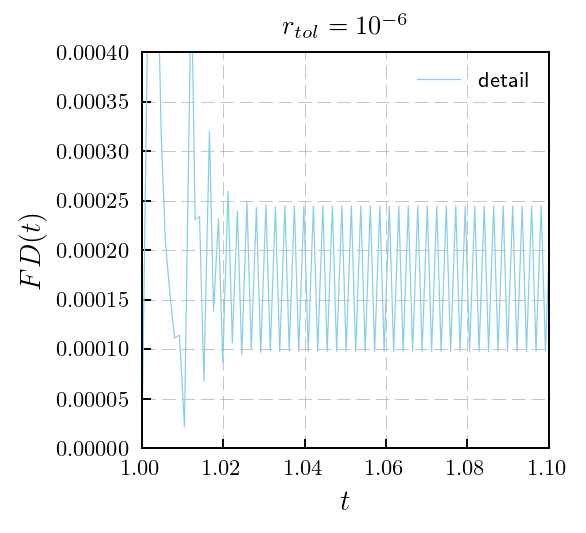

In [24]:
plt.figure(figsize=(3,3))
plt.plot(t_sol_1,FD_1, c='skyblue', linewidth=0.5, label=r'detail')
plt.xlim(1.0,1.1)
plt.ylim(0.0,0.0004)
plt.title('$r_{tol}= 10^{-6}$')
plt.xlabel('$t$', fontsize=12); plt.ylabel('$FD(t)$', fontsize=12)
plt.grid(ls='--', linewidth=0.3)
plt.legend(frameon=False, loc='upper right', fontsize=9)
plt.show()

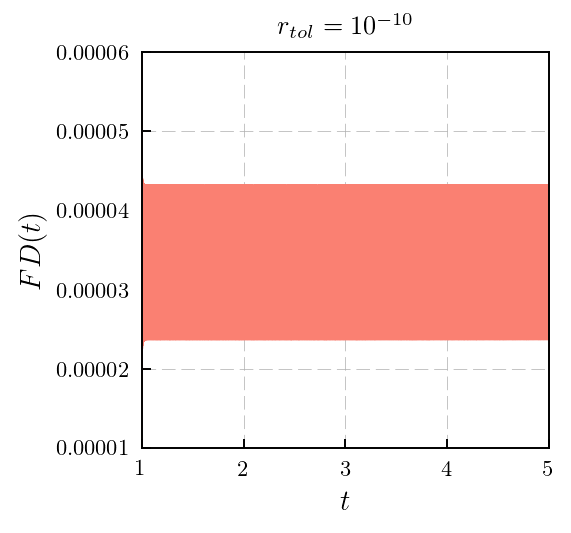

In [25]:
plt.figure(figsize=(3,3))
plt.plot(t_sol_2,FD_2, c='salmon', linewidth=0.5)
plt.xlim(1.0,5.0)
plt.ylim(0.00001,0.00006)
plt.title('$r_{tol}= 10^{-10}$')
plt.xlabel('$t$', fontsize=12); plt.ylabel('$FD(t)$', fontsize=12)
plt.grid(ls='--', linewidth=0.3)
plt.legend(frameon=False, loc='upper right', fontsize=9)
plt.show()

And a detail, as before:

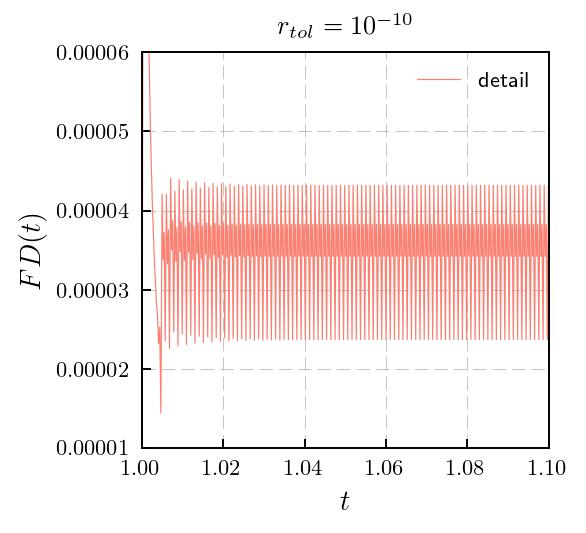

In [26]:
plt.figure(figsize=(3,3))
plt.plot(t_sol_2,FD_2, c='salmon', linewidth=0.5, label=r'detail')
plt.xlim(1.0,1.1)
plt.ylim(0.00001,0.00006)
plt.title('$r_{tol}= 10^{-10}$')
plt.xlabel('$t$', fontsize=12); plt.ylabel('$FD(t)$', fontsize=12)
plt.grid(ls='--', linewidth=0.3)
plt.legend(frameon=False, loc='upper right', fontsize=9)
plt.show()

### 1b) (10 points) Dealing with a stiff solution

Repeat the test of the previous exercise with $\tau_1 = 10^{-10}$ and $\tau_2 = 1$. Can your routine integrate the ODE in this case? If not, why not? Design and implement a replacement to the RKF45 routine that would allow you to deal with this situation (without changing the equation you integrate!), while still maintaining target fractional error accuracy via step size control.

#### Hints:

think implicit solvers. Also, note that you don't necessarily need a scheme of very high order to achieve target accuracy.

#### Required tests and follow up questions:

Demonstrate that your implemented scheme is able to integrate the ODE to the required input fractional error tolerance level, $r_{\rm tol}$ by plotting fractional error of the numerical solution relative to exact one as a function of $t$ for different target values of $r_{\rm tol}$

### Solution

Let's try to solve the equation -- and compare with the exact solution -- using our routine, for the case $\tau_1 = 10^{-10}$ and $\tau_2 = 1$.

We will use here a method based on the first and second order implicit schemes. 

The first order implicit scheme (backward Euler) is (eq. (2.95)) from the notes: 

\begin{equation}
y_{i+1} = y_i+ hf(x_{i+1}, y_{i+1}) + {\cal{O}}(h^2) \qquad (8)
\end{equation}

The second order implicit scheme (Crank-Nicolson scheme) is (see (2.96)):

\begin{equation}
y_{i+1} = y_i + \frac{h}{2}[f(x_i,y_i) + f(x_{i+1},y_{i+1})] + {\cal{O}}(h^3) \qquad (9)
\end{equation}

Differential equation (4) is linear, and thus we can solve (for this particular case) and get $y_{i+1}$ in an explicit form.

The first order gives:

\begin{equation}
y_{i+1,1} = \frac{y_i + h\left(\frac{1}{\tau_1} - \frac{1}{\tau_2} \right)e^{-(t+h)/\tau_2}}{1+h/\tau_1} \qquad (10)
\end{equation}

The second order gives:

\begin{equation}
y_{i+1,2} = \frac{y_i\left(1 - \frac{h}{2\tau_1} \right) + \frac{h}{2}\left(\frac{1}{\tau_1} - \frac{1}{\tau_2} \right)\left(1 + e^{-h/\tau_2} \right)e^{-t/\tau_2}}{1+h/2\tau_1} \qquad (11)
\end{equation}

Now the comparison is between schemes of the first and second order, and thus eq. (2) becomes ($n_l = 1)$:

\begin{equation}
h \to 0.9h\left(\frac{e_{tol}}{\tilde{e}_{i+1}}\right)^{0.5} \qquad (12)
\end{equation}

And similarly eq. (3):

\begin{equation}
h \to \max \left( 0.01h, \min\left(0.9h\left(\frac{e_{tol}}{\tilde{e}_{i+1}}\right)^{0.5}, 10.0h \right) \right) \qquad (13)
\end{equation}

Note the method presented here works only for this particular case; is not a general method. In more complex cases one may have to numerically solve the implicit equations (8), (9).

So, we repeat the procedure of the first question but checking the error between the 1st and 2nd order schemes (10) and (11).

In [27]:
def stiff_adaptive(fun, g, y_start, t_start, t_end, r_tol, *args):
    """
    Parameters: 
    ----------------------------------------------------------------------------
    fun - function object
              f(t, y, *args)
              
    g - function object 
              g(t, y, *args)
              
    y_start - float or vector of floats for system of equations
              initial value of y at t_start
    t_start - float 
              starting time
    t_end   - float
              end time
    r_tol   - float
              relative tolerance required 
    *args   - python list
              list of arguments to pass to f,
              
    Returns:  
    ----------------------------------------------------------------------------
    tout     - numpy float array
               time of each step 
    yout     - numpy float array
               solution y(tout)
               
    """
    
    # First of all define a constant, small, absolute tolerance, a_tol. We take it to be 1.0e-15 ~ close to the machine tolerance
    
    a_tol = 1.0e-15
    
    
    t, y = t_start, y_start; 
    tout = np.array(t); yout = np.array(y)
    
    #Define a starting time step i. Take it to be 1/10th of the time difference between t_end and t_start
    

    h = (t_end - t_start)/100.0

    while t < t_end:
        # Here we define two values of e and e_tol that satisfy e > e_tol in order to be sure that we will enter
        # the loop at least one time
        e =10.0             
        e_tol = 1.0
        while (e > e_tol):
            # temporary solutions till we find the 
            w_tp = fun(t, y, h, *args) #1st order scheme
            y_tp = g(t, y, h, *args) #2nd order scheme
            
            #abs difference between the two solutions
            
            e = np.abs(y_tp - w_tp)
            
            #Calculate absolute tolerance
            e_tol = a_tol + r_tol*abs(y_tp)
        
            #Calculate the time step h that we will actually use
        
            h = 0.9*h*((e_tol/e)**0.5)
        
       
        y = y_tp
        
        # new time   
        t += h      
        tout = np.vstack((tout,t)); yout = np.vstack((yout,y))
    return tout, yout

#==========================================================================
#==========================================================================
            
def fun(t, y, h, *args):
    "Equation (10)"
    
    tau_1 = args[0]
    tau_2 = args[1]
    
    upper = y + h*(1.0/tau_1 - 1.0/tau_2)*(np.exp(-(t+h)/tau_1))
    down = 1.0 + h/tau_2
    
    return upper/down
    
#--------------------------------------------------------------------------

def g(t, y, h, *args):
    "Equation (11)"
                
    tau_1 = args[0]
    tau_2 = args[1]
    
    upper = y*(1.0 - h/(2.0*tau_1)) + (h/2.0)*(1.0/tau_1 - 1.0/tau_2)*(1.0 + np.exp(-h/tau_2))*np.exp(-t/tau_2)
    
    down = 1.0 + h/(2.0*tau_1)
    
    return upper/down

###### Let's plot numerica and analytic solutions

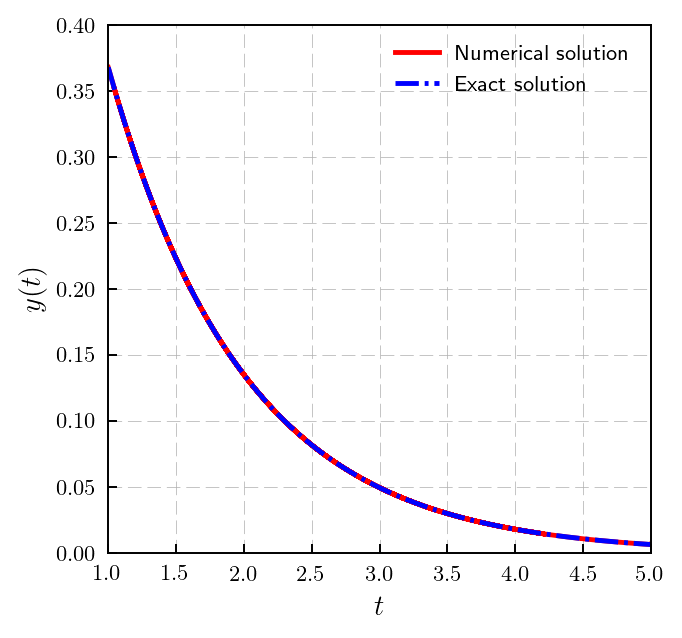

In [28]:
taf_1 = 1.0e-10
taf_2 = 1.0



#Numerical solution of the differential equation

I = stiff_adaptive(fun, g, 1.0/np.e, 1.0, 5.0, 1.0e-3, taf_1, taf_2)
t_sol_stiff, y_sol_stiff = I[0], I[1]


# Exact solution - using the same time steps as the numerical
y_exact_stiff = np.exp(-t_sol_stiff/taf_2) - np.exp(-t_sol_stiff/taf_1)

#=====================================================================
#=====================================================================
plt.figure(figsize=(4,4))


plt.plot(t_sol_stiff,y_sol_stiff, c='r', linewidth=2, label=r'Numerical solution' )

plt.plot(t_sol_stiff,y_exact_stiff, c='b', linewidth = 2, ls='-.', label =r'Exact solution')

plt.xlim(1.0,5.0)
plt.ylim(0.0,0.4)

plt.xlabel('$t$', fontsize=12); plt.ylabel('$y(t)$', fontsize=12)

plt.grid(ls='--', linewidth=0.3)

plt.legend(frameon=False, loc='upper right', fontsize=9)

plt.show()



### Let's calculate and  plot the fractional error now 

Calculated similarly to the case in problem 1a

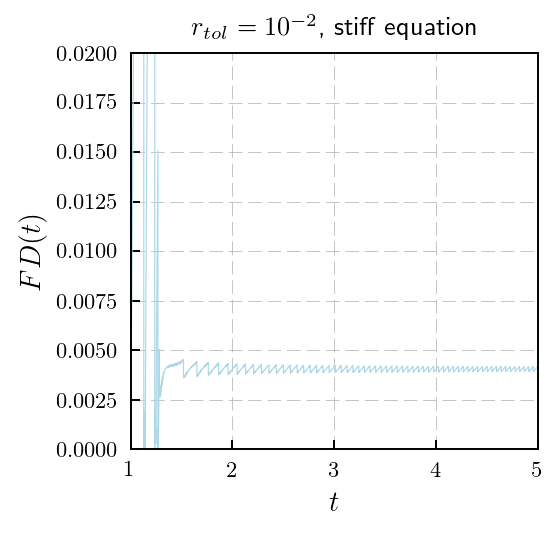

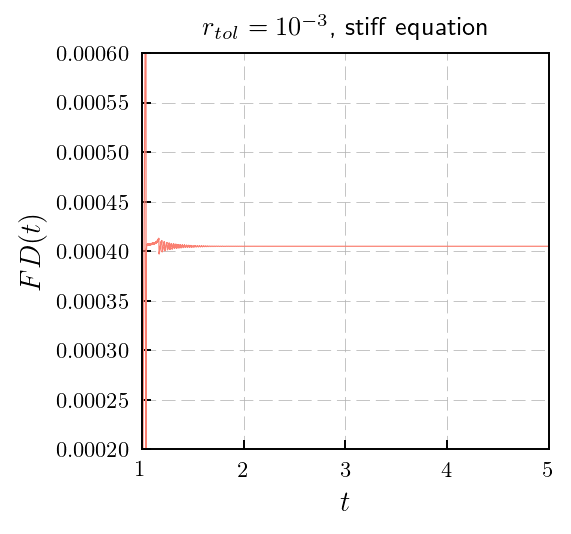

In [29]:
#===========================================================
#===========================================================
# Solution and frac error with r_tol = 10^{-2}
#Numerical solution of the differential equation
I = stiff_adaptive(fun, g, 1.0/np.e, 1.0, 5.0, 1.0e-2, taf_1, taf_2)
t_sol_1_st, y_sol_1_st = I[0], I[1]
# Exact solution - using the same time steps as the numerical
y_exact_1_st = np.exp(-t_sol_1_st/taf_2) - np.exp(-t_sol_1_st/taf_1)
#Calculation of the fractional error
FD_1_st = np.abs(y_sol_1_st - y_exact_1_st)/y_exact_1_st
#===========================================================
#===========================================================
# Solution and frac error with r_tol = 10^{-3}
#Numerical solution of the differential equation
J = stiff_adaptive(fun, g, 1.0/np.e, 1.0, 5.0, 1.0e-3, taf_1, taf_2)
t_sol_2_st, y_sol_2_st = J[0], J[1]
# Exact solution - using the same time steps as the numerical
y_exact_2_st = np.exp(-t_sol_2_st/taf_2) - np.exp(-t_sol_2_st/taf_1)
#Calculation of the fractional error
FD_2_st = np.abs(y_sol_2_st - y_exact_2_st)/y_exact_2_st

 #=========================================================================
#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#=========================================================================
#Plotting them 

plt.figure(figsize=(3,3))

plt.plot(t_sol_1_st,FD_1_st, c='lightblue', linewidth=0.5 )

plt.xlim(1.0,5.0)
plt.ylim(0.0,0.02)
plt.title('$r_{tol}= 10^{-2}$, stiff equation')
plt.xlabel('$t$', fontsize=12); plt.ylabel('$FD(t)$', fontsize=12)
plt.grid(ls='--', linewidth=0.3)
plt.legend(frameon=False, loc='upper right', fontsize=9)
plt.show()



plt.figure(figsize=(3,3))

plt.plot(t_sol_2_st,FD_2_st, c='salmon', linewidth=0.5 )

plt.xlim(1.0,5.0)
plt.ylim(0.0002,0.0006)
plt.title('$r_{tol}= 10^{-3}$, stiff equation')
plt.xlabel('$t$', fontsize=12); plt.ylabel('$FD(t)$', fontsize=12)
plt.grid(ls='--', linewidth=0.3)
plt.legend(frameon=False, loc='upper right', fontsize=9)
plt.show()

### And a little bit more zoomed 

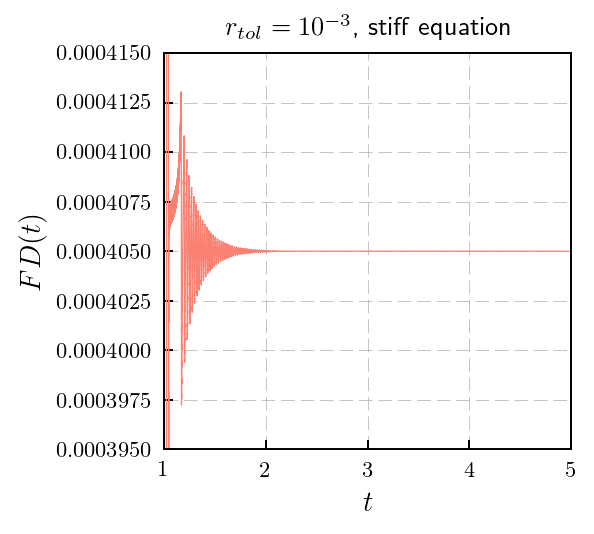

In [30]:
plt.figure(figsize=(3,3))

plt.plot(t_sol_2_st,FD_2_st, c='salmon', linewidth=0.5 )

plt.xlim(1.0,5.0)
plt.ylim(0.000395,0.000415)
plt.title('$r_{tol}= 10^{-3}$, stiff equation')
plt.xlabel('$t$', fontsize=12); plt.ylabel('$FD(t)$', fontsize=12)
plt.grid(ls='--', linewidth=0.3)
plt.legend(frameon=False, loc='upper right', fontsize=9)
plt.show()

### Problem 2 ) (25 points + 5 extra credit) Integrating particle orbits in $N$-body problems


### 2a) (20 points) Implementing code for $N$-body integration
Implement a *direct N-body code* which takes initial coordinates and velocities of $N$ particles and evolves them forward using a specified constant time step for some input number of steps. At each step and for each particle compute acceleration from other particles. After acceleration is computed, implement update of coordinates and velocities using either 1st order Euler scheme or the 2nd order symplectic integrator (KDK or DKD, see S 2.3.12  in the notes) to complete the step. 

For example, routine I implemented for this has the following inputs (you can implement it differently): 

    def nbody_integrate(nsteps, nsample, nprint, dt, x, v, mp, step, Etot, acc):
        """
        integrate equations of motions starting from the input vectors x, v, mp
        for nsteps with constant time step dt;
        
        Parameters: 
        ------------
        
        nsteps - integer
                the number of steps to take during integration
        nsample - integer
                record physical variables of particles (x, v, and Epot) only each nsample-th step
        nprint  - integer
                print physical quantities every nprint-th step
        dt - float
            step size
        x, v, mp - vectors of floats
             coordinates, velocities and masses of particles
        step - python function
            name of a user-supplied function to compute step using a given stepping scheme
            it should take x, v, mp, dt, dth=dt/2 as inputs
            
        Etot - python function 
            name of a user-supplied function to compute total energy for input x, v
             it should take into account the difference in time slices of x and v if such
             difference exists
        acc  - python function
            name of a user-supplied function to compute mutual accelerations of particles
            and/or accelerations from an external potential
        
        Returns:
        -----------------
        tt - numpy float vector
            recorded orbit times
        xt, vt, Ett - numpy float vectors
            coordinates, velocities, and total energies 
         
        these arrays are initialized as follows: 
            tt  = np.empty(nsteps/nsample+2)
            xt  = np.empty(shape=(nsteps/nsample+2,)+np.shape(x))
            Ett = np.empty(nsteps/nsample+2)
            vt  = np.empty(shape=(nsteps/nsample+2,)+np.shape(x))

    """

#### Useful info and hints: 
The evolution code should consist of a loop stepping in time.
For each particle acceleration is computed by direct summation of forces from all other particles and use it to advance positions of particles. Thus, to compute acceleration of all particles one has to have two loops over particles (which is what makes this problem scale as $N^2$). In python this second sweep can be done via vector operation, i.e. without explicit loop. With some effort both loops can be vectorized. I can show how this can be done in different ways in a code snippet at the end of the homework.  You can use these routines, but make sure you adjust them to use your code unit system.

Set up the calculation in such a way that units can be changed so you can use this routine to integrate different physical systems easily by redefining units at the beginning of the calculation. This means that your evolution routine should be written in abstract code units, which can be defined at the initialization. If you are not sure how to do this, please ask me. 
 More info on setting units and integration equations for this problem is provided in the Appendix A.3 of my <a href="http://astro.uchicago.edu/~andrey/classes/a330f17/notes.pdf">notes.</a>

Initialize coordinates and velocities before the first step half a step from each other using 1st order Euler scheme. How you do this depends whether you choose KDK or DKD stepping sequence (see S 1.4.5 in the notes).

#### Required tests and follow up questions: 
After you complete the routine, test it by integrating a two body system (ignoring other planets) - the Sun and the Earth with their true masses and with Earth on a circular orbit while the Sun is at rest - for at least 100 years (100 Earth orbits). Plot radius of the Earth orbit and its total energy as a function of time for the Euler and leapfrog schemes. How do results for these schemes compare? Discuss any obvious differences and their possible origin. (Note that at least one of these should show oscillating radius and energy but no net long term evolution of these quantities). Do results change/improve if you decrease step size significantly? 

### Solution

In [ ]:
def nbody_integrate(nsteps, nsample, nprint, dt, x, v, mp, G, step, Etot, acc):
    """
    integrate equations of motions starting from the input vectors x, v, mp
    for nsteps with constant time step dt;
        
    Parameters: 
    ------------
        
    nsteps - integer
             the number of steps to take during integration
    nsample - integer
            record physical variables of particles (x, v, and Epot) only each nsample-th step
    nprint  - integer
            print physical quantities every nprint-th step
    dt - float
            step size
    x, v, mp - vectors of floats
            coordinates, velocities and masses of particles
    step - python function
        name of a user-supplied function to compute step using a given stepping scheme
        it should take x, v, mp, dt, dth=dt/2 as inputs
            
    Etot - python function 
        name of a user-supplied function to compute total energy for input x, v
        it should take into account the difference in time slices of x and v if such
        difference exists
    acc  - python function
        name of a user-supplied function to compute mutual accelerations of particles
        and/or accelerations from an external potential
        
    Returns:
        -----------------
        tt - numpy float vector
            recorded orbit times
        xt, vt, Ett - numpy float vectors
            coordinates, velocities, and total energies 
         
        these arrays are initialized as follows: 
            tt  = np.empty(nsteps/nsample+2)
            xt  = np.empty(shape=(nsteps/nsample+2,)+np.shape(x))
            Ett = np.empty(nsteps/nsample+2)
            vt  = np.empty(shape=(nsteps/nsample+2,)+np.shape(x))

    """
    # Initialize arrays
    tt  = np.empty(nsteps/nsample+2)
    xt  = np.empty(shape=(nsteps/nsample+2,)+np.shape(x))
    Ett = np.empty(nsteps/nsample+2)
    vt  = np.empty(shape=(nsteps/nsample+2,)+np.shape(x))
    
    
    #Definitions
    
    
    # Initialize 
    t = 0   # Initialize time
    
    n = 0
    
    while (n <= nsteps): 
        n +=1
        t +=dt
        
        #Call the function step to calculate postion and velocity in the next step
        x,v = step(x,v,mp,dt,acc)
        
        if ((n%nsample)==0):
            i = n/nsample
            
            tt[i] = t
            xt[i,:] = x
            vt[i,:] = v
            Ett[i] = Etot(x,v,mp)
                
    
    return tt, xt, vt, Ett

    

#### Definition of the step functions

Here we define two different "step" functions (that can be used as inputs in the nbody_integrate function), actually the first and second order symplectic schemes. 

##### First order symplectic scheme - Euler

\begin{equation}
\mathbf{x}_{n+1} = \mathbf{x}_n + \tau_n \mathbf{p}_{n} \Rightarrow \mathbf{x_{n+1}} = \mathbf{x}_n + \tau_n m \mathbf{v}_{n}, \qquad (1a)
\end{equation}

\begin{equation}
\mathbf{p}_{n+1} = \mathbf{p}_n - \tau_n \nabla \phi(\mathbf{x_{n+1}}) \Rightarrow \mathbf{v}_{n+1} = \mathbf{v}_n + \tau_n \mathbf{a}(x_{n+1}) \qquad (1b)
\end{equation}

##### Second order symplectic scheme DKD

\begin{equation}
\mathbf{x}_1 = \mathbf{x}_n + \frac{1}{2}\tau_n \mathbf{p_n} \Rightarrow \mathbf{x}_1 = \mathbf{x}_n + \frac{1}{2}\tau_n  m \mathbf{v_n}  \qquad (2a) 
\end{equation}

\begin{equation}
\mathbf{p}_{n+1} = \mathbf{p}_n - \tau_n \nabla \phi(\mathbf{x}_1) = \mathbf{p}_n + \tau_n \mathbf{a}\qquad (2b)
\end{equation}

\begin{equation}
\mathbf{x}_{n+1} = \mathbf{x}_1 + \frac{1}{2} \tau_n \mathbf{p}_{n+1} \Rightarrow \mathbf{x}_{n+1} = \mathbf{x}_1 + \frac{1}{2} \tau_n m \mathbf{v}_{n+1} \qquad (2c) 
\end{equation}

Every time a function that calculates accelerations is also needed

In [ ]:
#========================================================================================
# Function that calculates new x,v using the Euler scheme

def Euler(x,v,mp,dt,acc):


#======================================================================================
#======================================================================================
# Function that calculates new x,v using DKD

def DKD(x,v,mp,dt,acc):
    
    


4.0
